# Phase II Modeling

In [1]:
import preprocessing
import wrangle
import model

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

import os.path
from os import path

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import re

from preprocessing_permits import permits_preprocessing_mother_function

In [2]:
features_for_modeling = ["ei", "city_state_high_density_bldgs_delta_pct", "avg_units_per_bldg", "value_per_bldg"]
label_feature = "should_enter"

In [3]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = permits_preprocessing_mother_function(modeling=True, features_for_modeling = features_for_modeling, label_feature = label_feature)

In [4]:
train_scaled

,ei,city_state_high_density_bldgs_delta_pct,avg_units_per_bldg,value_per_bldg
Albany_NY_1999,0.006478,0.031329,0.075276,0.039115
Albany_NY_2000,0.009346,0.023764,0.081101,0.040343
Albany_NY_2002,0.016666,0.031709,0.046848,0.039306
Albany_NY_2003,0.026397,0.035592,0.069641,0.055380
Albany_NY_2004,0.018215,0.053635,0.046473,0.057399
...,...,...,...,...
York_PA_2012,0.011721,0.028131,0.041284,0.057453
York_PA_2013,0.015334,0.071548,0.058382,0.039944
York_PA_2017,0.094161,0.198459,0.004893,0.042817
York_PA_2018,0.002948,0.003417,0.073394,0.071025


# Acquire

In [2]:
def rename_columns(df):
    """
    Docstring
    """
    
    # rename columns inplace
    df.rename(
        columns={
            "Date": "survey_date",
            "Code": "csa_code",
            "Code.1": "cbsa_code",
            "Unnamed: 3": "moncov",
            "Name": "cbsa_name",
            "Bldgs": "one_unit_bldgs_est",
            "Units": "one_unit_units_est",
            "Value": "one_unit_value_est",
            "Bldgs.1": "two_units_bldgs_est",
            "Units.1": "two_units_units_est",
            "Value.1": "two_units_value_est",
            "Bldgs.2": "three_to_four_units_bldgs_est",
            "Units.2": "three_to_four_units_units_est",
            "Value.2": "three_to_four_units_value_est",
            "Bldgs.3": "five_or_more_units_bldgs_est",
            "Units.3": "five_or_more_units_units_est",
            "Value.3": "five_or_more_units_value_est",
            "Bldgs.3": "five_or_more_units_bldgs_est",
            "Units.3": "five_or_more_units_units_est",
            "Value.3": "five_or_more_units_value_est",
            "Bldgs.4": "one_unit_bldgs_rep",
            "Units.4": "one_unit_units_rep",
            "Value.4": "one_unit_value_rep",
            "Bldgs.5": "two_units_bldgs_rep",
            "Units.5": "two_units_units_rep",
            "Value.5": "two_units_value_rep",
            "      Bldgs": "three_to_four_units_bldgs_rep",
            "Units.6": "three_to_four_units_units_rep",
            "Value.6": "three_to_four_units_value_rep",
            "Bldgs.6": "five_or_more_units_bldgs_rep",
            "Units.7": "five_or_more_units_units_rep",
            "Value.7": "five_or_more_units_value_rep",
        },
        inplace=True,
        )
    
    return df

In [3]:
def acquire_building_permits():
    """
    Docstring
    """
    
    # conditional
    if path.exists("building_permits.csv"):
        
        # read csv
        df = pd.read_csv("building_permits.csv", index_col=0)
        
    else:
    
        # create original df with 2019 data
        df = pd.read_csv("https://www2.census.gov/econ/bps/Metro/ma2019a.txt", sep=",", header=1)

        # rename columns
        rename_columns(df)

        for i in range(1980, 2019):

            # read the txt file at url where i is the year in range
            year_df = pd.read_csv(
                f"https://www2.census.gov/econ/bps/Metro/ma{i}a.txt",
                sep=",",
                header=1,
                names=df.columns.tolist(),
            )
            
            # append data to global df variable
            df = df.append(year_df, ignore_index=True)

        # make moncov into bool so that the null observations of this feature are not considered in the dropna below
        df["moncov"] = np.where(df.moncov == "C", 1, 0)

        # dropna inplace
        df.dropna(inplace=True)
        
        # chop off the succeding two digits after the year for survey_date
        df["survey_date"] = df.survey_date.astype(str).apply(lambda x: re.sub(r"\d\d$", "", x))
        
        # add a preceding "19" to any years where the length of the observation is 2 (e.i., "80"-"97")
        df["survey_date"] = df.survey_date.apply(lambda x: "19" + x if len(x) == 2 else x)
        
        # turn survey_date back into an int
        df["survey_date"] = df.survey_date.astype(int)
        
        # turn moncov back into a bool
        df["moncov"] = df.moncov.astype(bool)
        
        # sort values by survey_date
        df.sort_values(by=["survey_date"])
        
        # reset index inplace
        df.reset_index(inplace=True)
        
        # drop former index inplace
        df.drop(columns=["index"], inplace=True)
        
        # write df to disk as csv
        df.to_csv("building_permits.csv")
    
    return df

In [4]:
df_model = acquire_building_permits()
print(f"""Our DataFrame contains {df_model.shape[0]:,} observations and {df_model.shape[1]} features.""")
df_model

Our DataFrame contains 14,149 observations and 29 features.


,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,...,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
1,2019,104.0,24020.0,False,Glens Falls NY,229.0,229.0,57598.0,0.0,0.0,...,37724.0,0.0,0.0,0.0,2.0,6.0,746.0,1.0,6.0,781.0
2,2019,106.0,10740.0,True,Albuquerque NM,1872.0,1872.0,446893.0,1.0,2.0,...,296615.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,188.0,20079.0
3,2019,106.0,42140.0,True,Santa Fe NM,344.0,344.0,78685.0,0.0,0.0,...,78685.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,245.0,30037.0
4,2019,107.0,11020.0,False,Altoona PA,111.0,111.0,24333.0,0.0,0.0,...,22834.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018,999.0,48540.0,False,Wheeling WV-OH,9.0,9.0,1435.0,2.0,4.0,...,1327.0,2.0,4.0,300.0,1.0,3.0,270.0,1.0,100.0,12500.0
14145,2018,999.0,48660.0,False,Wichita Falls TX,117.0,117.0,26725.0,4.0,8.0,...,26725.0,4.0,8.0,420.0,0.0,0.0,0.0,8.0,195.0,17999.0
14146,2018,999.0,48900.0,False,Wilmington NC,1868.0,1868.0,521252.0,16.0,32.0,...,405914.0,12.0,24.0,4802.0,5.0,20.0,1956.0,14.0,473.0,69781.0
14147,2018,999.0,49420.0,False,Yakima WA,480.0,480.0,111572.0,16.0,32.0,...,106541.0,16.0,32.0,4670.0,14.0,51.0,7210.0,2.0,15.0,1609.0


In [5]:
df_model.sort_values(by=["survey_date"], ascending=False)

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,...,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
193,2019,430.0,48260.0,False,Weirton-Steubenville WV-OH,25.0,25.0,5782.0,0.0,0.0,...,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,2019,999.0,10180.0,False,Abilene TX,354.0,354.0,72824.0,8.0,16.0,...,72596.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0
262,2019,566.0,49660.0,False,Youngstown-Warren-Boardman OH-PA,323.0,323.0,73182.0,2.0,4.0,...,50054.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0
261,2019,558.0,48700.0,False,Williamsport PA,66.0,66.0,16215.0,6.0,12.0,...,12095.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1980,5745.0,9999.0,False,NORTHEAST PENNSYLVANIA SMSA,1146.0,1146.0,42642.0,3.0,6.0,...,39843.0,3.0,6.0,91.0,6.0,23.0,440.0,5.0,627.0,15798.0
566,1980,5720.0,9999.0,False,NORFOLK-VIRGINIA BEACH-,2806.0,2806.0,146250.0,110.0,220.0,...,146250.0,110.0,220.0,6606.0,61.0,231.0,7896.0,201.0,1521.0,44621.0
565,1980,5680.0,9999.0,False,NEWPORT NEWS-HAMPTON SMSA,1435.0,1435.0,65952.0,2.0,4.0,...,65952.0,2.0,4.0,30.0,0.0,0.0,0.0,25.0,192.0,3146.0
564,1980,5640.0,9999.0,False,NEWARK SMSA,2156.0,2156.0,137423.0,59.0,118.0,...,137349.0,59.0,118.0,3407.0,13.0,47.0,1927.0,32.0,1343.0,40208.0


In [6]:
df_model.survey_date.min(), df_model.survey_date.max()

(1980, 2019)

In [7]:
df_model.survey_date.value_counts().sort_index(ascending=False)

2019    384
2018    382
2017    382
2016    382
2015    381
2014    381
2013    366
2012    366
2011    366
2010    366
2009    366
2008    363
2007    363
2006    361
2005    361
2004    361
2003    361
2002    349
2001    349
2000    349
1999    349
1998    348
1997    346
1996    346
1995    344
1994    342
1993    341
1992    355
1991    355
1990    355
1989    354
1988    353
1987    352
1986    352
1985    352
1984    328
1983    318
1982    318
1981    318
1980    284
Name: survey_date, dtype: int64

In [8]:
df_model.groupby("cbsa_name").five_or_more_units_value_rep.mean()

cbsa_name
ABILENE SMSA                         14871.250000
ABILENE TX MSA. . . . . . . . . .     1850.000000
ABILENE TX. . . . . . . . . . . .    12140.000000
AKRON OH (P). . . . . . . . . . .    13780.000000
AKRON OH PMSA . . . . . . . . . .    15799.500000
                                         ...     
Yuba City CA MSA                      1989.222222
Yuba City CA MSA. . . . . . . . .     7920.000000
Yuma  AZ                              2274.117647
Yuma  AZ MSA                          5409.666667
Yuma AZ MSA                           3112.428571
Name: five_or_more_units_value_rep, Length: 2639, dtype: float64

In [9]:
df_model[(df_model.cbsa_name.str.contains("ABILENE"))]

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
384,1980,40.0,9999.0,False,ABILENE SMSA,569.0,569.0,40702.0,7.0,14.0,...,40144.0,7.0,14.0,542.0,5.0,20.0,555.0,2.0,352.0,5995.0
668,1981,40.0,9999.0,False,ABILENE SMSA,550.0,550.0,43510.0,20.0,40.0,...,42157.0,20.0,40.0,1831.0,11.0,40.0,1415.0,18.0,268.0,4525.0
986,1982,40.0,9999.0,False,ABILENE SMSA,788.0,788.0,53100.0,27.0,54.0,...,51675.0,27.0,54.0,2539.0,4.0,14.0,505.0,61.0,1280.0,26975.0
1304,1983,40.0,9999.0,False,ABILENE SMSA,1072.0,1072.0,71385.0,69.0,138.0,...,68857.0,69.0,138.0,8556.0,25.0,99.0,2541.0,7.0,744.0,21990.0
1622,1984,40.0,9999.0,False,ABILENE TX. . . . . . . . . . . .,501.0,501.0,36623.0,31.0,62.0,...,34225.0,31.0,62.0,3094.0,24.0,96.0,2070.0,40.0,520.0,12140.0
1950,1985,40.0,9999.0,False,ABILENE TX MSA. . . . . . . . . .,385.0,385.0,32929.0,4.0,8.0,...,31190.0,4.0,8.0,268.0,0.0,0.0,0.0,1.0,65.0,3000.0
2302,1986,40.0,9999.0,False,ABILENE TX MSA. . . . . . . . . .,335.0,335.0,28675.0,1.0,2.0,...,26230.0,1.0,2.0,124.0,3.0,12.0,599.0,1.0,10.0,700.0


In [10]:
df_model[df_model.survey_date > 1998].sort_values(by = "survey_date", ascending=True).cbsa_name.value_counts().tail(60)

Milwaukee-Racine  WI CMSA                         4
Colorado Springs  CO MSA                          4
Newburgh  NY-PA PMSA                              4
Clarksville-Hopkinsville  TN-KY MSA               4
Florence  SC MSA                                  4
Stockton-Lodi  CA MSA                             4
Visalia-Tulare-Porterville  CA MSA                4
Hickory-Morganton-Lenoir  NC MSA                  4
Erie  PA MSA                                      4
San Angelo  TX MSA                                4
Parkersburg-Marietta  WV-OH MSA                   4
Anniston  AL MSA                                  4
Pittsfield  MA MSA                                4
Laredo  TX MSA                                    4
Sharon  PA MSA                                    4
Sacramento  CA PMSA                               4
Boulder-Longmont  CO PMSA                         4
Boise City  ID MSA                                4
Columbia  SC MSA                                  4
Buffalo-Niag

We need to find the cities that have the most number of continuous data.

In [11]:
(df_model.groupby("cbsa_name").survey_date.count().sort_values() == 17).sum()

260

In [12]:
df_model[df_model["five_or_more_units_value_est"] == 0.0].groupby("cbsa_name").three_to_four_units_value_rep.sum()

cbsa_name
ALBANY SMSA                            92.0
ALEXANDRIA SMSA                      1610.0
ALTOONA PA MSA. . . . . . . . . .       0.0
ALTOONA SMSA                           22.0
ANDERSON IN . . . . . . . . . . .     879.0
                                      ...  
Yuba City  CA                           0.0
Yuba City  CA MSA                       0.0
Yuba City CA MSA                      120.0
Yuma  AZ                             2281.0
Yuma AZ MSA                          1318.0
Name: three_to_four_units_value_rep, Length: 585, dtype: float64

In [13]:
df_model.shape

(14149, 29)

# Prepare

Things that need to get done:

* standarized the name of the cities so that they are all uniform. Need to make sure that when we do a groupby, cities aren't being overlook, or that there are duplicates.
* Can we do a loop using `str.contains()` to add city names together in an effort to standarized the names. Use a double_split ("  ") to create a split between the name and the state

In [14]:
df_model[df_model.cbsa_name.str.contains("Austin") == True]

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
270,2019,999.0,12420.0,False,Austin-Round Rock-Georgetown TX,18426.0,18426.0,4407360.0,127.0,254.0,...,4301979.0,127.0,254.0,30255.0,23.0,90.0,9743.0,362.0,13267.0,1353284.0
2672,1987,640.0,9999.0,False,Austin TX MSA . . . . . . . . . .,2374.0,2374.0,184764.0,16.0,32.0,...,184401.0,16.0,32.0,1238.0,0.0,0.0,0.0,36.0,1000.0,19080.0
3024,1988,640.0,9999.0,False,Austin TX MSA,2020.0,2020.0,189301.0,5.0,10.0,...,188956.0,5.0,10.0,314.0,3.0,12.0,353.0,6.0,305.0,21017.0
3377,1989,640.0,9999.0,False,Austin TX MSA,1888.0,1888.0,210895.0,7.0,14.0,...,210476.0,7.0,14.0,826.0,0.0,0.0,0.0,1.0,8.0,600.0
3731,1990,640.0,9999.0,False,Austin TX MSA,1900.0,1900.0,225997.0,5.0,10.0,...,225997.0,5.0,10.0,641.0,9.0,36.0,649.0,0.0,0.0,408.0
4086,1991,640.0,9999.0,False,Austin TX MSA,2971.0,2971.0,315935.0,2.0,4.0,...,315773.0,2.0,4.0,154.0,1.0,4.0,120.0,19.0,220.0,6739.0
4441,1992,640.0,9999.0,False,Austin TX MSA,4619.0,4619.0,456421.0,13.0,26.0,...,453296.0,13.0,26.0,1502.0,2.0,8.0,448.0,49.0,996.0,18489.0
4793,1993,640.0,9999.0,False,Austin-San Marcos TX MSA,6318.0,6318.0,684125.0,41.0,82.0,...,677205.0,41.0,82.0,3487.0,2.0,8.0,173.0,145.0,2084.0,56326.0
5134,1994,640.0,9999.0,False,Austin-San Marcos TX MSA,6267.0,6267.0,664682.0,49.0,98.0,...,655380.0,47.0,94.0,4664.0,5.0,17.0,728.0,213.0,4403.0,150516.0
5476,1995,640.0,9999.0,False,Austin-San Marcos TX MSA,7435.0,7435.0,769718.0,72.0,144.0,...,747124.0,72.0,144.0,6925.0,16.0,53.0,2439.0,289.0,6133.0,226891.0


In [15]:
df_model["city"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[0]

In [16]:
df_model["state"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[1]

In [17]:
df_model

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep,city,state
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,...,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0,Albany-Schenectady-Troy,NY
1,2019,104.0,24020.0,False,Glens Falls NY,229.0,229.0,57598.0,0.0,0.0,...,0.0,0.0,2.0,6.0,746.0,1.0,6.0,781.0,Glens Falls,NY
2,2019,106.0,10740.0,True,Albuquerque NM,1872.0,1872.0,446893.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,188.0,20079.0,Albuquerque,NM
3,2019,106.0,42140.0,True,Santa Fe NM,344.0,344.0,78685.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,245.0,30037.0,Santa Fe,NM
4,2019,107.0,11020.0,False,Altoona PA,111.0,111.0,24333.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Altoona,PA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018,999.0,48540.0,False,Wheeling WV-OH,9.0,9.0,1435.0,2.0,4.0,...,4.0,300.0,1.0,3.0,270.0,1.0,100.0,12500.0,Wheeling,WV-OH
14145,2018,999.0,48660.0,False,Wichita Falls TX,117.0,117.0,26725.0,4.0,8.0,...,8.0,420.0,0.0,0.0,0.0,8.0,195.0,17999.0,Wichita Falls,TX
14146,2018,999.0,48900.0,False,Wilmington NC,1868.0,1868.0,521252.0,16.0,32.0,...,24.0,4802.0,5.0,20.0,1956.0,14.0,473.0,69781.0,Wilmington,NC
14147,2018,999.0,49420.0,False,Yakima WA,480.0,480.0,111572.0,16.0,32.0,...,32.0,4670.0,14.0,51.0,7210.0,2.0,15.0,1609.0,Yakima,WA


In [18]:
df_model.state.str.split(" ", 1, expand= True)[1].value_counts()

            6281
MSA         1533
PMSA         438
CMSA         108
 AR           11
 AR MSA        6
Name: 1, dtype: int64

In [19]:
df_model[df_model.state.str.contains(" AR") == True]

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep,city,state
6452,1997,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,170.0,170.0,11657.0,2.0,4.0,...,4.0,175.0,1.0,4.0,137.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
6800,1998,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,155.0,155.0,11127.0,2.0,4.0,...,4.0,181.0,0.0,0.0,0.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
7149,1999,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,214.0,214.0,16882.0,3.0,6.0,...,6.0,213.0,0.0,0.0,0.0,1.0,144.0,5000.0,Texarkana,TX-Texarkana AR MSA
7498,2000,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,263.0,263.0,19044.0,0.0,0.0,...,0.0,0.0,39.0,156.0,3965.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
7847,2001,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,220.0,220.0,20524.0,11.0,22.0,...,22.0,843.0,0.0,0.0,0.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR MSA
8196,2002,8360.0,9999.0,False,Texarkana TX-Texarkana AR MSA,224.0,224.0,19162.0,10.0,20.0,...,20.0,1133.0,0.0,0.0,0.0,12.0,144.0,3300.0,Texarkana,TX-Texarkana AR MSA
8582,2003,999.0,45500.0,False,Texarkana TX-Texarkana AR,276.0,276.0,28107.0,48.0,96.0,...,96.0,4615.0,2.0,7.0,350.0,24.0,272.0,12388.0,Texarkana,TX-Texarkana AR
8943,2004,999.0,45500.0,False,Texarkana TX-Texarkana AR,251.0,251.0,24429.0,36.0,72.0,...,72.0,3143.0,0.0,0.0,0.0,1.0,8.0,290.0,Texarkana,TX-Texarkana AR
9305,2005,999.0,45500.0,False,Texarkana TX-Texarkana AR,220.0,220.0,24143.0,14.0,28.0,...,28.0,1339.0,0.0,0.0,0.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR
9666,2006,999.0,45500.0,False,Texarkana TX-Texarkana AR,199.0,199.0,21171.0,12.0,24.0,...,24.0,1484.0,1.0,3.0,130.0,0.0,0.0,0.0,Texarkana,TX-Texarkana AR


In [20]:
df_model[(df_model.city.str.contains("San Antonio") == True) & (df_model.survey_date > 2000)].sort_values(by="survey_date", ascending=True)

,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,...,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep,city,state
7810,2001,7240.0,9999.0,False,San Antonio TX MSA,9138.0,9138.0,852069.0,49.0,98.0,...,98.0,4754.0,23.0,91.0,6066.0,226.0,3376.0,137953.0,San Antonio,TX MSA
8159,2002,7240.0,9999.0,False,San Antonio TX MSA,10051.0,10051.0,958393.0,68.0,136.0,...,136.0,5329.0,20.0,79.0,3657.0,181.0,2506.0,98159.0,San Antonio,TX MSA
8561,2003,999.0,41700.0,False,San Antonio TX,10976.0,10976.0,1514260.0,49.0,98.0,...,98.0,6355.0,16.0,62.0,3689.0,153.0,2236.0,131227.0,San Antonio,TX
8922,2004,999.0,41700.0,False,San Antonio TX,12634.0,12634.0,1806941.0,130.0,260.0,...,260.0,15268.0,26.0,104.0,5747.0,239.0,4538.0,281043.0,San Antonio,TX
9283,2005,999.0,41700.0,True,San Antonio TX,14706.0,14706.0,2224823.0,90.0,180.0,...,178.0,12598.0,29.0,116.0,6317.0,358.0,7018.0,555759.0,San Antonio,TX
9644,2006,999.0,41700.0,True,San Antonio TX,13841.0,13841.0,2230500.0,69.0,138.0,...,138.0,10401.0,100.0,400.0,28960.0,268.0,5186.0,432455.0,San Antonio,TX
10011,2007,999.0,41700.0,True,San Antonio TX,9350.0,9350.0,1672335.0,46.0,92.0,...,92.0,7028.0,54.0,216.0,19464.0,150.0,3408.0,348370.0,San Antonio,TX
10374,2008,999.0,41700.0,True,San Antonio TX,6010.0,6010.0,1106607.0,43.0,86.0,...,84.0,6366.0,26.0,101.0,7697.0,200.0,4331.0,316173.0,San Antonio,TX
10740,2009,999.0,41700.0,True,San Antonio TX,5486.0,5486.0,1018287.0,10.0,20.0,...,20.0,1625.0,17.0,60.0,5099.0,22.0,338.0,24314.0,San Antonio,TX
11107,2010,999.0,41700.0,True,San Antonio-New Braunfels TX,5144.0,5144.0,952167.0,6.0,12.0,...,12.0,830.0,10.0,40.0,2002.0,86.0,1620.0,97374.0,San Antonio-New Braunfels,TX


In [21]:
df_model["major_city"] = df_model.city.str.split("-", 1, expand=True)[0]

In [22]:
df_model["major_state"] = df_model.state.str.split("-", 1, expand=True)[0]

In [23]:
df_model["metropolitan_area"] = df_model.state.str.split("-", 1, expand=True)[1]

In [24]:
df_model["metropolitan_area"] = df_model.major_state.str.split(" ", 1, expand=True)[1]

In [25]:
df_model["major_state"] = df_model.major_state.str.split(" ", 1, expand=True)[0]

In [26]:
df = df_model.groupby(["major_city","major_state", "survey_date"]).sum().reset_index()

In [27]:
df[df.major_city == "Dallas"]

,major_city,major_state,survey_date,csa_code,cbsa_code,moncov,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,...,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
1820,Dallas,TX,1997,3844.0,11919.0,False,45995.0,45995.0,6524521.0,123.0,...,6335299.0,116.0,232.0,13261.0,147.0,580.0,31507.0,1493.0,30895.0,1342156.0
1821,Dallas,TX,1998,3844.0,11919.0,False,54636.0,54636.0,7893946.0,160.0,...,7538240.0,147.0,294.0,20901.0,196.0,770.0,41860.0,2017.0,38106.0,1810402.0
1822,Dallas,TX,1999,3844.0,11919.0,False,55541.0,55541.0,8229454.0,118.0,...,8045751.0,111.0,222.0,11580.0,109.0,430.0,22207.0,1486.0,27021.0,1289653.0
1823,Dallas,TX,2000,3844.0,11919.0,False,61887.0,61887.0,9834957.0,103.0,...,9648086.0,94.0,188.0,9633.0,177.0,682.0,41241.0,786.0,14004.0,1010833.0
1824,Dallas,TX,2001,3844.0,11919.0,False,63547.0,63547.0,9882317.0,112.0,...,9557666.0,84.0,168.0,13377.0,86.0,332.0,35349.0,958.0,21153.0,1072002.0
1825,Dallas,TX,2002,3844.0,11919.0,False,63253.0,63253.0,10184181.0,182.0,...,9984660.0,174.0,348.0,31469.0,395.0,1569.0,79793.0,1032.0,20849.0,1078415.0
1826,Dallas,TX,2003,206.0,19100.0,True,40537.0,40537.0,6447004.0,116.0,...,6209501.0,110.0,220.0,16551.0,170.0,661.0,22087.0,576.0,11206.0,611339.0
1827,Dallas,TX,2004,206.0,19100.0,True,45908.0,45908.0,7543649.0,154.0,...,7344658.0,147.0,294.0,17668.0,28.0,103.0,8685.0,381.0,7470.0,428709.0
1828,Dallas,TX,2005,206.0,19100.0,True,49489.0,49489.0,8591102.0,221.0,...,8262329.0,215.0,430.0,23899.0,40.0,149.0,12872.0,500.0,9760.0,692993.0
1829,Dallas,TX,2006,206.0,19100.0,True,43591.0,43591.0,8442367.0,298.0,...,8275611.0,295.0,590.0,40524.0,86.0,329.0,40238.0,456.0,11998.0,979997.0


In [28]:
def prep_building_permits(df_model):
    df_model["city"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[0]
    df_model["state"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[1]
    df_model["major_city"] = df_model.city.str.split("-", 1, expand=True)[0]
    df_model["major_state"] = df_model.state.str.split("-", 1, expand=True)[0]
    df_model["metropolitan_area"] = df_model.state.str.split("-", 1, expand=True)[1]
    df_model["metropolitan_area"] = df_model.major_state.str.split(" ", 1, expand=True)[1]
    df_model["major_state"] = df_model.major_state.str.split(" ", 1, expand=True)[0]
    df_model = df_model.groupby(["major_city","major_state", "survey_date"]).sum().reset_index()

    return df_model

def filter_top_cities_building_permits(df):
    df["city_state"] = df["major_city"] + "_" + df["major_state"]
    city_mask = df.groupby("city_state").survey_date.count()
    city_mask = city_mask[city_mask == 23]
    # apply city mask to shrink the df
    def in_city_mask(x):
        return x in city_mask
    df = df[df.city_state.apply(in_city_mask)]
    df = df.sort_values(["major_city", "major_state", "survey_date"])
    return df

# Explore

In [29]:
df_model = acquire_building_permits()

In [30]:
df_model = prep_building_permits(df_model)

In [31]:
df_model = filter_top_cities_building_permits(df_model)

In [32]:
df_model.major_state.value_counts().nlargest(10)

TX    529
CA    460
PA    299
FL    276
NC    253
OH    230
IN    230
WI    230
NY    207
AL    207
Name: major_state, dtype: int64

In [33]:
# What is the state with the most number of new constructions?

df_model.groupby("major_state").five_or_more_units_units_est.sum().nlargest(10)

major_state
TX    1139721.0
CA     923796.0
FL     732612.0
NY     702766.0
WA     299937.0
NC     286265.0
DC     283573.0
IL     277652.0
GA     272668.0
CO     264478.0
Name: five_or_more_units_units_est, dtype: float64

In [34]:
# What is the state with the most money in new construction?

df_model.groupby("major_state").five_or_more_units_value_est.sum().nlargest(10)

major_state
CA    115712478.0
TX     82346917.0
FL     74554108.0
NY     65771423.0
WA     30850629.0
IL     25697142.0
CO     23327193.0
DC     22036535.0
GA     21491351.0
NC     20346113.0
Name: five_or_more_units_value_est, dtype: float64

Text(0.5, 0, 'Year')

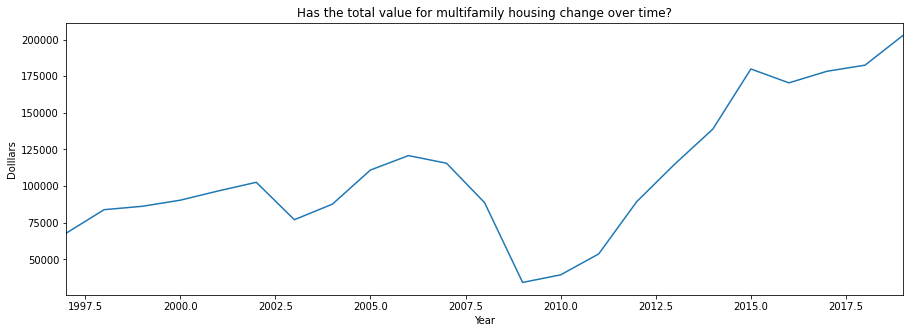

In [35]:
# Has the number of new buildings change over time?

df_model.groupby("survey_date").five_or_more_units_value_est.mean().plot.line(figsize=(15,5))
plt.title("Has the total value for multifamily housing change over time?")
plt.ylabel("Dolllars")
plt.xlabel("Year")

Text(0.5, 0, 'Year')

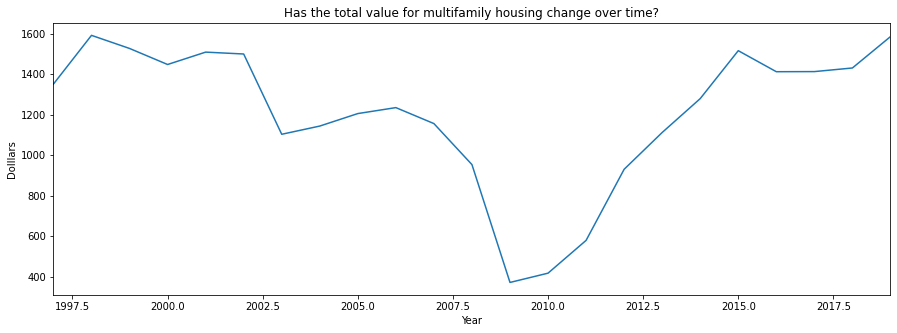

In [36]:
# Has the value for buildings change over time?

df_model.groupby("survey_date").five_or_more_units_units_est.mean().plot.line(figsize=(15,5))
plt.title("Has the total value for multifamily housing change over time?")
plt.ylabel("Dolllars")
plt.xlabel("Year")

In [37]:
# Are there any patterns in Houston 2009, Seattle 2010 and Dallas 2012?
houston = df_model[df_model.major_city == "Houston"]

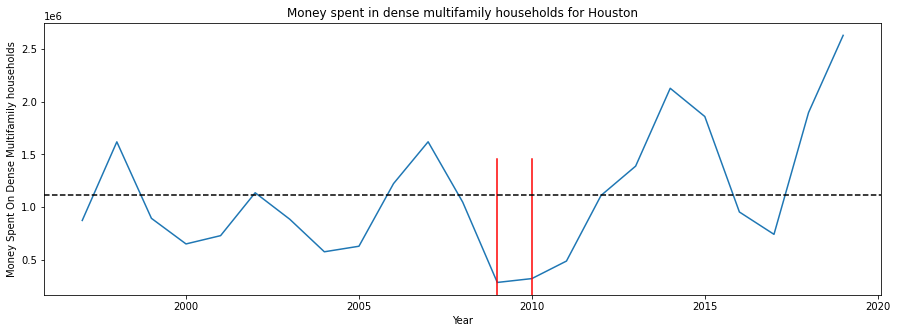

In [38]:
plt.figure(figsize=(15,5))
sns.lineplot(data=houston, x="survey_date", y="five_or_more_units_value_est")
plt.title("Money spent in dense multifamily households for Houston")
plt.ylabel("Money Spent On Dense Multifamily households")
plt.xlabel("Year")
plt.axvline(2009, 0,.5, color="r")
plt.axvline(2010, 0,.5, color="r")
plt.axhline(houston.five_or_more_units_value_est.mean(), ls='--', color="Black")

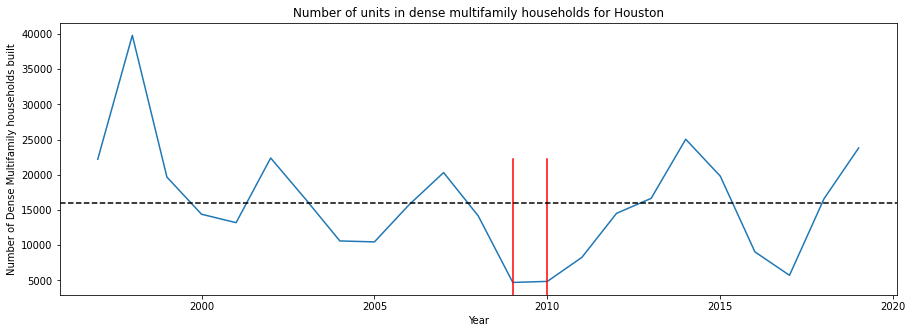

In [39]:
plt.figure(figsize=(15,5))
sns.lineplot(data=houston, x="survey_date", y="five_or_more_units_units_est")
plt.title("Number of units in dense multifamily households for Houston")
plt.ylabel("Number of Dense Multifamily households built")
plt.xlabel("Year")
plt.axvline(2009, 0,.5, color="r")
plt.axvline(2010, 0,.5, color="r")
plt.axhline(houston.five_or_more_units_units_est.mean(), ls='--', color="Black")

In [40]:
# Are there any patterns in Houston 2009, Seattle 2010 and Dallas 2012?
seattle = df_model[df_model.major_city == "Seattle"]

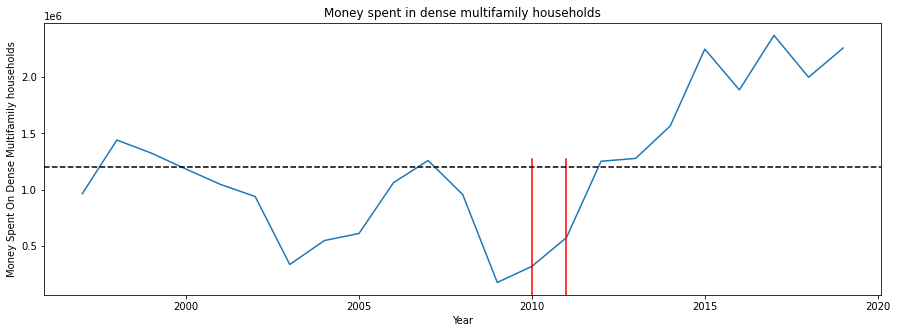

In [41]:
plt.figure(figsize=(15,5))
sns.lineplot(data=seattle, x="survey_date", y="five_or_more_units_value_est")
plt.title("Money spent in dense multifamily households")
plt.ylabel("Money Spent On Dense Multifamily households")
plt.xlabel("Year")
plt.axvline(2010, 0,.5, color="r")
plt.axvline(2011, 0,.5, color="r")
plt.axhline(seattle.five_or_more_units_value_est.mean(), ls='--', color="Black")

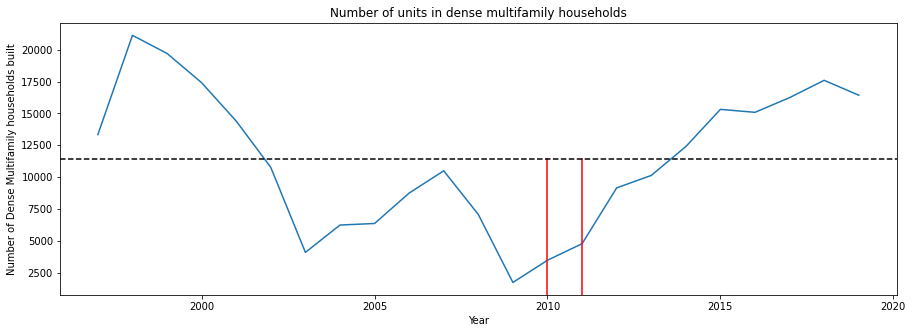

In [42]:
plt.figure(figsize=(15,5))
sns.lineplot(data=seattle, x="survey_date", y="five_or_more_units_units_est")
plt.title("Number of units in dense multifamily households")
plt.ylabel("Number of Dense Multifamily households built")
plt.xlabel("Year")
plt.axvline(2010, 0,.5, color="r")
plt.axvline(2011, 0,.5, color="r")
plt.axhline(seattle.five_or_more_units_units_est.mean(), ls='--', color="Black")

In [43]:
# Are there any patterns in Houston 2009, Seattle 2010 and Dallas 2012?
dallas = df_model[df_model.major_city == "Dallas"]

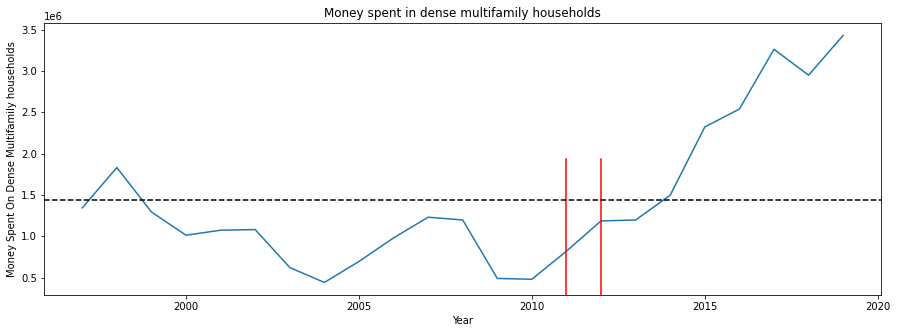

In [44]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dallas, x="survey_date", y="five_or_more_units_value_est")
plt.title("Money spent in dense multifamily households")
plt.ylabel("Money Spent On Dense Multifamily households")
plt.xlabel("Year")
plt.axvline(2011, 0,.5, color="r")
plt.axvline(2012, 0,.5, color="r")
plt.axhline(dallas.five_or_more_units_value_est.mean(), ls='--', color="Black")

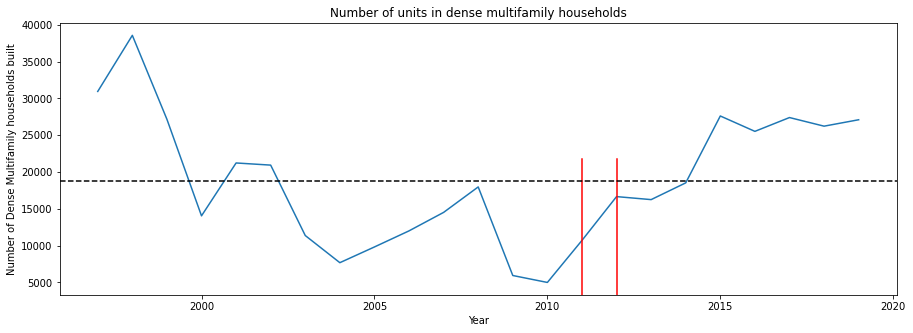

In [45]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dallas, x="survey_date", y="five_or_more_units_units_est")
plt.title("Number of units in dense multifamily households")
plt.ylabel("Number of Dense Multifamily households built")
plt.xlabel("Year")
plt.axvline(2011, 0,.5, color="r")
plt.axvline(2012, 0,.5, color="r")
plt.axhline(dallas.five_or_more_units_units_est.mean(), ls='--', color="Black")

In [46]:
def filter_top_cities_building_permits(df):
    """
    This function masks df in two ways:
    city_mask returns cities with only continuously reported data
    threshold_mask returns cities where they had at least one "5 or more unit" building permit for every year
    Returns 130 cities for modeling
    """
    df["city_state"] = df["major_city"] + "_" + df["major_state"]
    city_mask = df.groupby("city_state").survey_date.count()
    city_mask = city_mask[city_mask == 23]
    # apply city mask to shrink the df
    def in_city_mask(x):
        return x in city_mask
    df = df[df.city_state.apply(in_city_mask)]
    threshold_mask = df_model.groupby('city_state').five_or_more_units_bldgs_est.agg(lambda x: (x == 0).sum())
    threshold_mask = threshold_mask[threshold_mask < 1].index.tolist()
    # apply threshold mask to shrink the df 
    def in_threshold_mask(x):
        return x in threshold_mask
    df = df[df.city_state.apply(in_threshold_mask)]
    df = df.sort_values(["major_city", "major_state", "survey_date"])
    return df

In [47]:
df_model = filter_top_cities_building_permits(df_model)

In [48]:
df_model["avg_cost_per_building"] = df_model.five_or_more_units_value_est / df_model.five_or_more_units_bldgs_est

Text(0.5, 1.0, 'Avg cost per building over time')

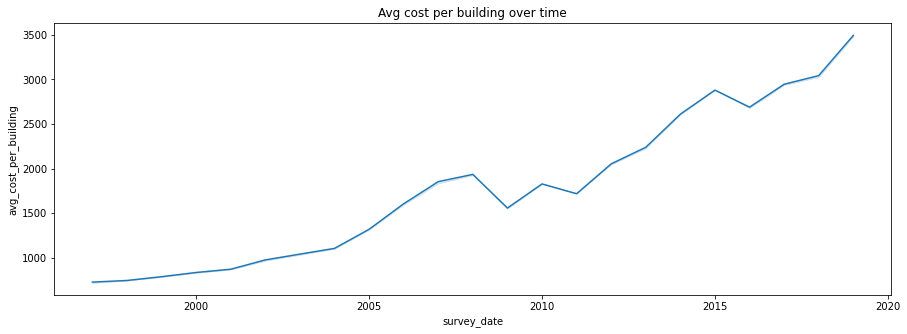

In [49]:
# Has the avg cost per building increased over time?
plt.figure(figsize=(15,5))
sns.lineplot(data=df_model, x="survey_date", y="avg_cost_per_building", ci=False)
plt.title("Avg cost per building over time")

In [50]:
df_model["avg_units"] = df_model.five_or_more_units_units_est / df_model.five_or_more_units_bldgs_est

Text(0.5, 1.0, 'Avg number of units per building over time')

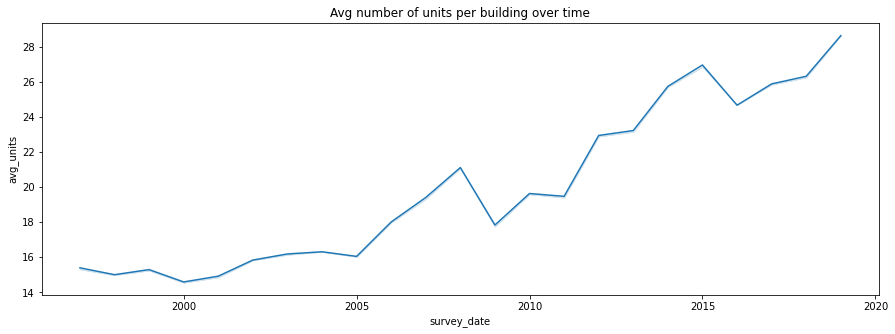

In [51]:
# Has the avg number of units change over time?
plt.figure(figsize=(15,5))
sns.lineplot(data = df_model, x="survey_date", y="avg_units", ci=False)
plt.title("Avg number of units per building over time")

Text(0.5, 1.0, 'Number of units built over time')

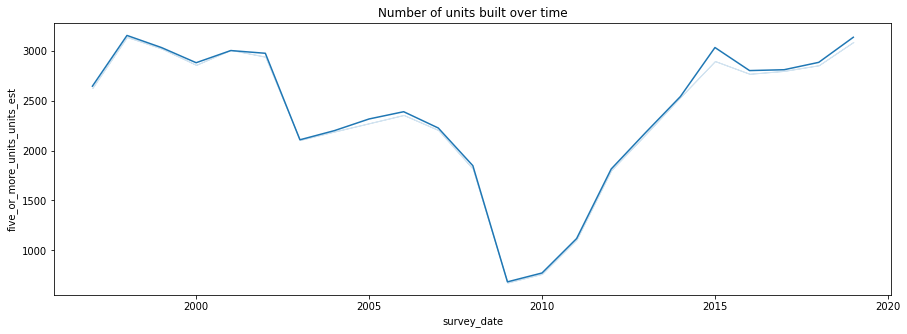

In [52]:
plt.figure(figsize=(15,5))
sns.lineplot(data = df_model, x="survey_date", y="five_or_more_units_units_est", ci=False)
plt.title("Number of units built over time")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

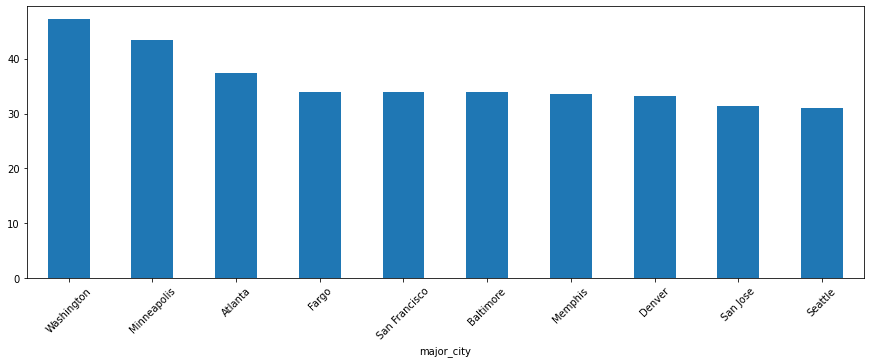

In [53]:
# What cities have the most dense buildings, on avg?

df_model.groupby("major_city").avg_units.mean().nlargest(10).plot.bar(figsize=(15,5))
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

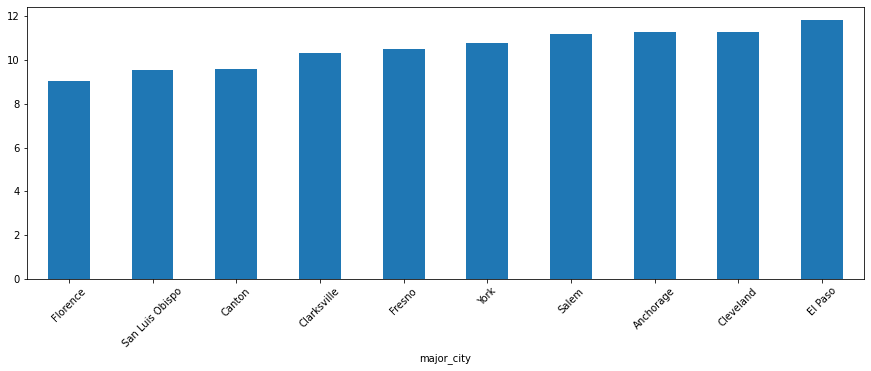

In [54]:
# What cities have the least dense buildings, on avg?

df_model.groupby("major_city").avg_units.mean().nsmallest(10).plot.bar(figsize=(15,5))
plt.xticks(rotation=45)

# Model

In [4]:
def labeling_future_data(df):
    """this function takes in a data frame and returns a boolean column that identifies
    if a city_state_year is a market that should be entered"""
    df["five_or_more_units_bldgs_est_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["five_or_more_units_bldgs_est"]]
                                  .pct_change(2)
                                  .shift(-2))
    df["five_or_more_units_value_est_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["five_or_more_units_value_est"]]
                                  .pct_change(2)
                                  .shift(-2))
    Q3 = df.five_or_more_units_bldgs_est_2y.quantile(.75)
    Q1 = df.five_or_more_units_bldgs_est_2y.quantile(.25)
    upper_fence_quantity = Q3 + ((Q3-Q1)*1.5)
    upper_fence_quantity
    Q3 = df.five_or_more_units_value_est_2y.quantile(.75)
    Q1 = df.five_or_more_units_value_est_2y.quantile(.25)
    upper_fence_volume = Q3 + ((Q3-Q1)*1.5)
    upper_fence_volume
    df['should_enter'] = (df.five_or_more_units_value_est_2y > upper_fence_volume) | (df.five_or_more_units_bldgs_est_2y > upper_fence_quantity)
    return df

In [5]:
df = preprocessing.permits_preprocessing_mother_function()

In [6]:
(df.should_enter).mean()

0.10568561872909699

In [7]:
def split_data(df, train_size=.75,random_state = 124):
    train, test = train_test_split(df, train_size=train_size, random_state=random_state, stratify = df["should_enter"])
    train, validate = train_test_split(train, train_size=train_size, random_state=random_state, stratify = train["should_enter"])
    return train, validate, test

def return_values(scaler, train, validate, test):
    '''
    Helper function used to updated the scaled arrays and transform them into usable dataframes
    '''
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled

# Linear scaler
def min_max_scaler(train,validate, test):
    '''
    Helper function that scales that data. Returns scaler, as well as the scaled dataframes
    '''
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, train, validate, test)
    return scaler, train_scaled, validate_scaled, test_scaled

def prep_data_for_modeling_permits(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 1997]

    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]

    features_for_modeling += [label_feature]

    data = df_model[features_for_modeling].set_index("observation_id")
    
    train, validate, test = split_data(data)
    train = train.sort_values("observation_id")
    validate = validate.sort_values("observation_id")
    test = test.sort_values("observation_id")
    
    
    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_validate = validate.drop(columns=label_feature)
    y_validate = validate[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]
    
    scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(X_train, X_validate, X_test)

    return train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test



In [8]:
features_for_modeling = ["ei", "city_state_high_density_bldgs_delta_pct", "avg_units_per_bldg", "value_per_bldg"]
label_feature = "should_enter"

In [9]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = prep_data_for_modeling_permits(df, features_for_modeling, label_feature)

# Decision Tree

In [10]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

In [11]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 2, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 3, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 4, accuracy_score = 0.89. validate_score = 0.89, recall = 0.03
Max_depth = 5, accuracy_score = 0.89. validate_score = 0.89, recall = 0.03
Max_depth = 6, accuracy_score = 0.89. validate_score = 0.89, recall = 0.06
Max_depth = 7, accuracy_score = 0.90. validate_score = 0.89, recall = 0.11
Max_depth = 8, accuracy_score = 0.91. validate_score = 0.89, recall = 0.17
Max_depth = 9, accuracy_score = 0.92. validate_score = 0.88, recall = 0.27
Max_depth = 10, accuracy_score = 0.93. validate_score = 0.87, recall = 0.35
Max_depth = 11, accuracy_score = 0.94. validate_score = 0.87, recall = 0.50
Max_depth = 12, accuracy_score = 0.95. validate_score = 0.85, recall = 0.57
Max_depth = 13, accuracy_score = 0.96. validate_score = 0.86, recall = 0.63
Max_depth = 14, accur

In [12]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [13]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.89
       False  True 
False   1426      4
True     172      6


,False,True,accuracy,macro avg,weighted avg
precision,0.892365,0.600000,0.890547,0.746183,0.860002
recall,0.997203,0.033708,0.890547,0.515455,0.890547
f1-score,0.941876,0.063830,0.890547,0.502853,0.844679
support,1430.000000,178.000000,0.890547,1608.000000,1608.000000


In [14]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == train_scaled.shape[1])
coef = clf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

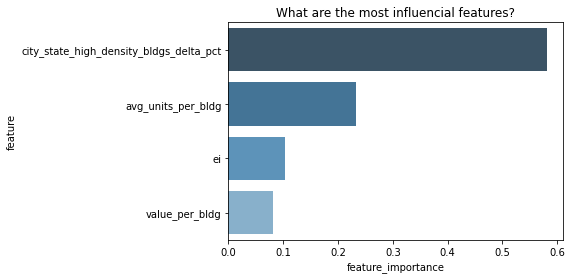

In [15]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. The total `quantity_of_mortgages_pop` doesn't seem to be as influencial in the predictions.

# Random Forest

In [16]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(rf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 2, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 3, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 4, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 5, accuracy_score = 0.89. validate_score = 0.89, recall = 0.00
Max_depth = 6, accuracy_score = 0.89. validate_score = 0.89, recall = 0.01
Max_depth = 7, accuracy_score = 0.89. validate_score = 0.89, recall = 0.02
Max_depth = 8, accuracy_score = 0.90. validate_score = 0.89, recall = 0.07
Max_depth = 9, accuracy_score = 0.90. validate_score = 0.89, recall = 0.10
Max_depth = 10, accuracy_score = 0.91. validate_score = 0.89, recall = 0.23
Max_depth = 11, accuracy_score = 0.92. validate_score = 0.89, recall = 0.28
Max_depth = 12, accuracy_score = 0.94. validate_score = 0.89, recall = 0.44
Max_depth = 13, accuracy_score = 0.95. validate_score = 0.89, recall = 0.58
Max_depth = 14, accur

In [17]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [18]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.89
       False  True 
False   1430      0
True     178      0


,False,True,accuracy,macro avg,weighted avg
precision,0.889303,0.0,0.889303,0.444652,0.790861
recall,1.000000,0.0,0.889303,0.500000,0.889303
f1-score,0.941409,0.0,0.889303,0.470704,0.837198
support,1430.000000,178.0,0.889303,1608.000000,1608.000000


In [20]:
coef = rf.feature_importances_
columns = train_scaled.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

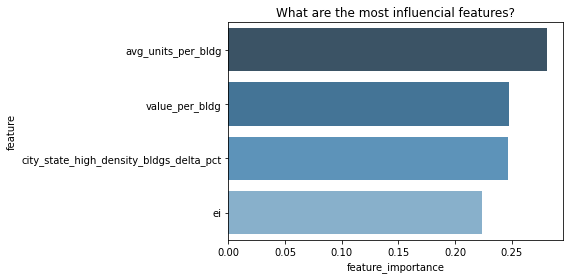

In [21]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Interestingly, for the random_forest model, the delta of the number of loans approved by city where the most important or influencial indicator of whether a city would be `a hot martket` or not. The evolution index was the second most influencial feature. Again, the total `quantity_of_morgages_pop` was the least influencial feature.

# KNN

In [22]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(knn, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.80, recall = 1.00
Max_depth = 2, accuracy_score = 0.90. validate_score = 0.88, recall = 0.13
Max_depth = 3, accuracy_score = 0.91. validate_score = 0.86, recall = 0.23
Max_depth = 4, accuracy_score = 0.90. validate_score = 0.89, recall = 0.07
Max_depth = 5, accuracy_score = 0.89. validate_score = 0.88, recall = 0.10
Max_depth = 6, accuracy_score = 0.89. validate_score = 0.89, recall = 0.03
Max_depth = 7, accuracy_score = 0.89. validate_score = 0.89, recall = 0.06
Max_depth = 8, accuracy_score = 0.89. validate_score = 0.89, recall = 0.03
Max_depth = 9, accuracy_score = 0.89. validate_score = 0.89, recall = 0.03
Max_depth = 10, accuracy_score = 0.89. validate_score = 0.89, recall = 0.01
Max_depth = 11, accuracy_score = 0.89. validate_score = 0.89, recall = 0.02
Max_depth = 12, accuracy_score = 0.89. validate_score = 0.89, recall = 0.01
Max_depth = 13, accuracy_score = 0.89. validate_score = 0.89, recall = 0.01
Max_depth = 14, accur

In [23]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)
predictions["knn"] = y_pred

In [24]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.90
       False  True 
False   1430      0
True     155     23


,False,True,accuracy,macro avg,weighted avg
precision,0.902208,1.000000,0.903607,0.951104,0.913033
recall,1.000000,0.129213,0.903607,0.564607,0.903607
f1-score,0.948590,0.228856,0.903607,0.588723,0.868918
support,1430.000000,178.000000,0.903607,1608.000000,1608.000000


In [25]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.89
Decision_Tree = 0.89
Random_Forest = 0.89
Knn = 0.90


In [26]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.03
Random_Forest = 0.00
Knn = 0.13


In [27]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.60
Random_Forest = 0.00
Knn = 1.00


## Conclusion:

Overall, we see that because we have optimized for *recall*, the accuracy scores are a bit lower than expected. However, our recall scores are really good. We will choose the KNN model as the most effective model, given that it consistently achieved the best scores (for accuracy, recall and precision). 

# Evaluate

In [28]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)

In [29]:
y_pred = rf.predict(test_scaled)

In [30]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.89
       False  True 
False    636      0
True      79      0


,False,True,accuracy,macro avg,weighted avg
precision,0.889510,0.0,0.88951,0.444755,0.791229
recall,1.000000,0.0,0.88951,0.500000,0.889510
f1-score,0.941525,0.0,0.88951,0.470762,0.837496
support,636.000000,79.0,0.88951,715.000000,715.000000


---

In [31]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)

In [32]:
y_pred = knn.predict(test_scaled)

In [33]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.88
       False  True 
False    630      6
True      79      0


,False,True,accuracy,macro avg,weighted avg
precision,0.888575,0.0,0.881119,0.444288,0.790397
recall,0.990566,0.0,0.881119,0.495283,0.881119
f1-score,0.936803,0.0,0.881119,0.468401,0.833296
support,636.000000,79.0,0.881119,715.000000,715.000000


----

# Prediction

In [34]:
df = preprocessing.get_model_df()
df = preprocessing.add_new_features(df)
df = filter_top_cities(df)

KeyError: 'total_high_density_units'

In [ ]:
df.head()

In [ ]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [ ]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

In [ ]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [ ]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [ ]:
predictions["label"] = rf.predict(predictions_scaled)

In [ ]:
predictions

In [ ]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [ ]:
predictions = predictions.reset_index()

In [ ]:
predictions["city"] = city

predictions["state"] = state

In [ ]:
predictions

In [ ]:
predictions[predictions.label == True]

In [ ]:
predictions.to_csv("predictions.csv")

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()

In [ ]:
def permits_preprocessing_mother_function(modeling=False, features_for_modeling = [], label_feature= " "):
    """
    Docstring
    """
    if modeling == False
        # call get_permits_